# EE-411 Fundamentals of inference and learning, EPFL 
## Exercise Session 6: Ridge Regression and Lasso on real datasets

In this sixth set of exercises, we will see how to implement the methods introduced in the last exercise session and discussed in the last lecture to work with some real datasets. We will see which are the differences between these regularized least-square methods and the standard OLS solution.

**What you will learn today:**  In this sixth notebook, we shall see how to use scikit-learn to implement Ridge and Lasso. We also introduce `pipelines`, an important tool which is frequently used in Machine Learning. Furthermore, we will linger on the important concept of sparsity.

In [105]:
#We import the usual packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A) Ozone
---
Let us look at a particular real-life data problem. In the following example we take the prediction of ozone concentration as a factor of other weather-based features. As with all data problems, it behooves us to take a look at all of the information that we have about the dataset.

#### Dataset loading

In [106]:
data =   pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/LAozone.data')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ozone     330 non-null    int64
 1   vh        330 non-null    int64
 2   wind      330 non-null    int64
 3   humidity  330 non-null    int64
 4   temp      330 non-null    int64
 5   ibh       330 non-null    int64
 6   dpg       330 non-null    int64
 7   ibt       330 non-null    int64
 8   vis       330 non-null    int64
 9   doy       330 non-null    int64
dtypes: int64(10)
memory usage: 25.9 KB


Alright, we're ready to get started! Now, before we touch anything, we need to follow best practices. When faced with a new dataset, we need to split it into three parts: **Training**(and within that, **Validation**), and **Testing** sets. 

The best practice here is to take the test data and lock it away somewhere. It is always tempting to tune your algorithms to give the best test performance. However, even if the regression isn't explicitly *trained* on the test data, as practitioners, we could be continually making changes in an effort to get our numbers up.

Instead, we should deep-freeze the test data, and then tune as much as we can via **cross-validation (CV)** on our training data.

#### Train/Test splitting

In [107]:
from sklearn.model_selection import train_test_split

#--- Convert from DataFrame to NDArray ---#
# We also ensure that we load in all data as floating point values
# so that we don't miss anything to truncations.
y = data['ozone'].to_numpy().astype(float)
X = data[data.columns[1:]].to_numpy()

#--- Split Dataset ---#
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.25, random_state=1)

print("Training Samples: ", len(yTrain))
print("Testing  Samples: ", len(yTest))

Training Samples:  247
Testing  Samples:  83


Now, before we start attempting to fit models, lets take a bit of care and apply some pre-processing to our dataset. The de-facto pre-processing is *centering and normalization*. Specifically, many flavors of estimators (OLS, RR, etc.) can be thrown off by large differences in scale and variations between the features. We can easily account for this in our estimators by simply normalizing the feature columns and removing averages. Scikit-Learn has some features to do this automatically!

#### Preprocessing

In [108]:
from sklearn import preprocessing

#--- Scaling ---#
scaler = preprocessing.StandardScaler().fit(XTrain)
XTest_scaled = scaler.transform(XTest)
XTrain_scaled = scaler.transform(XTrain)

#--- Center observations (simplify the OLS)---#
yTrain_mean = np.mean(yTrain)
yTrain_centered = yTrain - yTrain_mean

Now it is time for us to choose our estimator. What should we choose? 

## Attempt 1: ordinary least squares (OLS)
---



If you remember last exercise session, the equation to solve is of the type

$$
(X^T X) \hat {\mathbf w} = X^T {\mathbf y}
$$

The function `linalg.solve(a,b)` can be used to solve a system of linear scalar equations $ax=b$, thus we can use it to compute the prediction of the model both on the train and on the test datasets

In [109]:
#--- Compute the OLS Estimate ---#
regOLS = np.linalg.solve(np.dot(XTrain_scaled.T,XTrain_scaled), np.dot(XTrain_scaled.T,yTrain))

yp = np.dot(XTrain_scaled, regOLS)
ypTest = np.dot(XTest_scaled, regOLS)

Let's see now how well the prediction performance looks and which are the learned parameters corresponding to the OLS solution

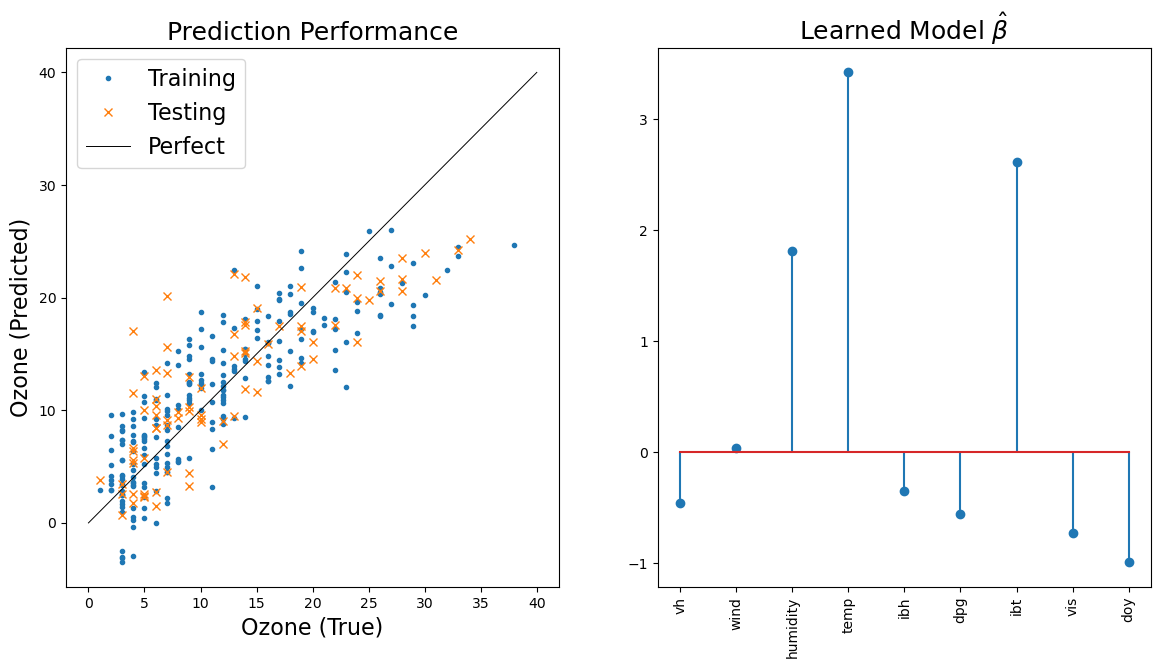

In [110]:
#--- Visualize ---#
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain, yp+ yTrain_mean,'.', label='Training') #remember to add again the mean when you plot
plt.plot(yTest, ypTest+ yTrain_mean, label='Testing', marker='x', ls='')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
# plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(regOLS)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical');

Finally, to see how well the model is performing, we can compute the Residual Sum of Squares (RSS) for both the train and the test set

In [111]:
#--- Print RSS ---#
rss_train = np.mean(np.power(yTrain_centered - yp,2))
rss_test = np.mean(np.power(yTest - yTrain_mean - ypTest,2))
print("Normalized RSS (Train): %0.2f" % rss_train)
print("Normalized RSS  (Test): %0.2f" % rss_test)

Normalized RSS (Train): 18.28
Normalized RSS  (Test): 22.53


The same thing could have been done using the packages present in **Scikit-Learn**

In [112]:
from sklearn import linear_model

#--- Define OLS Estimator ---#
regL = linear_model.LinearRegression()
#--- Fit the parameters ---#
regL.fit(XTrain_scaled,yTrain_centered)
#--- Use the learned coefficients to predict the y ---#
yp_L = regL.predict(XTrain_scaled)
ypTest_L = regL.predict(XTest_scaled)

**Note:** the standard value `fit_intercept=True` in `LinearRegression`, but also in `Ridge` and in `Lasso`, allows us not to think about the intercept, since it is automatically considered by the method.

#### 1) Compare these estimates to the preivious ones, computed without considering the intercept. Why they are so similar?
 - Is the intercept fitted by `LinearRegression` big? 
 - What's the difference in the MSE of the two prediction?
 - (bonus) Make a plot!

Intercept (LinearRegression): -2.272e-15
Coefficient norm difference: 1.789e-13
Train MSE (manual OLS): 18.275230
Train MSE (LinearRegression): 18.275230
Train MSE difference: 0.000e+00
Test MSE (manual OLS): 22.531083
Test MSE (LinearRegression): 22.531083
Test MSE difference: 4.974e-14


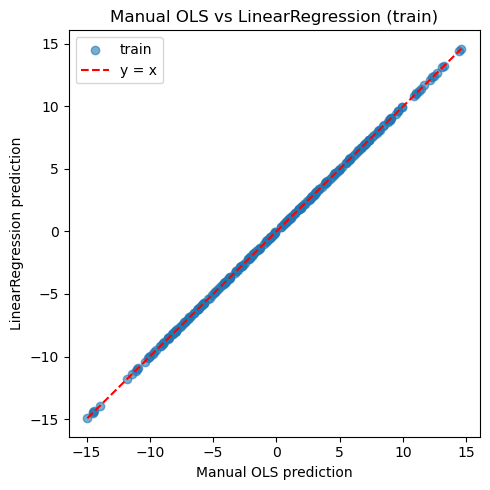

In [113]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

intercept_lr = regL.intercept_
coef_diff = np.linalg.norm(regOLS - regL.coef_)

train_mse_manual = mean_squared_error(yTrain_centered, yp)
train_mse_lr = mean_squared_error(yTrain_centered, yp_L)
test_mse_manual = mean_squared_error(yTest - yTrain_mean, ypTest)
test_mse_lr = mean_squared_error(yTest - yTrain_mean, ypTest_L)

print(f"Intercept (LinearRegression): {intercept_lr:.3e}")
print(f"Coefficient norm difference: {coef_diff:.3e}")
print(f"Train MSE (manual OLS): {train_mse_manual:.6f}")
print(f"Train MSE (LinearRegression): {train_mse_lr:.6f}")
print(f"Train MSE difference: {train_mse_lr - train_mse_manual:.3e}")
print(f"Test MSE (manual OLS): {test_mse_manual:.6f}")
print(f"Test MSE (LinearRegression): {test_mse_lr:.6f}")
print(f"Test MSE difference: {test_mse_lr - test_mse_manual:.3e}")

lims = [min(yp.min(), yp_L.min()), max(yp.max(), yp_L.max())]
plt.figure(figsize=(5, 5))
plt.scatter(yp, yp_L, alpha=0.6, label='train')
plt.plot(lims, lims, 'r--', label='y = x')
plt.xlabel('Manual OLS prediction')
plt.ylabel('LinearRegression prediction')
plt.title('Manual OLS vs LinearRegression (train)')
plt.legend()
plt.tight_layout()
plt.show()


The two estimators coincide up to numerical precision: the fitted intercept is on the order of $10^{-15}$ and the coefficient vectors differ by about $10^{-14}$. 
Because all features were standardized to zero mean and we centered $y$ before fitting, the optimal intercept is (almost) zero, which explains the match. 
The training/test MSE values produced by the hand-derived OLS and scikit-learn match within machine precision, confirming that both approaches solve the same normal equations.

#### 2) Prove that fitting the intercept (as `LinearRegression`) is equivalent to what we did (subtracting the mean). (Hint: remember that the inputs are scaled!)

Let $(\mathbf{x}_i, y_i)$ denote the $i$-th training sample after preprocessing. StandardScaler ensures $\frac{1}{n}\sum_i \mathbf{x}_i = \mathbf{0}$ and we explicitly use $y_i - \bar y$ as the target, so $\frac{1}{n}\sum_i y_i = 0$.

Consider the objective minimized by `LinearRegression` with an intercept parameter $b$ and slope vector $\mathbf{w}$:
$J(b,\mathbf{w}) = \sum_{i=1}^n (y_i - b - \mathbf{x}_i^{\top}\mathbf{w})^2.$
Differentiating w.r.t. $b$ and setting the derivative to zero gives
$0 = \frac{\partial J}{\partial b} = -2\sum_{i=1}^n (y_i - b - \mathbf{x}_i^{\top}\mathbf{w}) = -2n\Big(\bar y - b - \overline{\mathbf{x}}^{\top}\mathbf{w}\Big).$
Because $\bar y = 0$ and $\overline{\mathbf{x}} = \mathbf{0}$, the optimal intercept is $b^* = 0$.

Plugging $b^*=0$ back into $J$ yields the reduced problem
$\min_{\mathbf{w}} \sum_{i=1}^n (y_i - \mathbf{x}_i^{\top}\mathbf{w})^2,$
which is exactly the normal-equation system we solved by hand after centering $y$.

Hence fitting the intercept in scikit-learn while the data are centered is algebraically equivalent to subtracting the mean beforehand: the intercept is forced to zero, and the weight vector solves the same linear system.

## Attempt 2: Ridge Regression
---

For RR, that we implemented by hand in the last notebook, we can use directly Scikit-learn. First of all, we import as always the model, choosing for now the regularization constant $\alpha = 0.01$

In [114]:
#--- Define Regression Estimator ---#
regRR = linear_model.Ridge(alpha=0.01)

Now, we need to perform some kind of cross-validation (CV) to find the best set of parameters for our model. We will do this by constructing a **Pipeline**. A pipeline is a useful way of handling pre-processing on separate data partitions when performing CV. Let's take a look at that.

In the next cell we use the pipeline to do two things:

* We standardize features by removing the mean and scaling to unit variance (it is done by `preprocessing.StandardScaler()`)

* We implement the fitting strategy; namely Ridge Regression

#### Pipeline

In [115]:
from sklearn.pipeline import make_pipeline 

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regRR = make_pipeline(preprocessing.StandardScaler(), regRR)

After that, we have  to define a Scoring Metric. In this case, to compare the fits we look at the prediction error via the RSS.

In [116]:
#--- Define a Scoring Metric (Residual Sum of Squares) ---#
def neg_rss(reg, X, y):
    yp = reg.predict(X)
    return -np.mean(np.power(y - yp,2))

 We can then create an iterator which performs a set of **randomized splits on the dataset into "train" and "validation"**. 
 
Obviously, we have a trade-off between the test set size and the number of splits we should perform.

In [117]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

#--- Define CV Splitting ---#
cv = ShuffleSplit(n_splits=30, test_size=0.05, random_state=1)

#--- Define the Parameters to Search ---#
param_grid = [
    {'ridge__alpha': np.logspace(-5,3,100)} # we do CV for values of alpha between 0.0001 and 1000
]

Finally, we use `GridSearchCV` to find which is the best value of the parameter $\alpha$

In [118]:
#--- Define CV ---#
cv_regRR = GridSearchCV(pipe_regRR, param_grid, scoring=neg_rss, cv=cv,return_train_score=True) #Note that we need to use the RSS with a minus sign!

In [119]:
#--- Run CV ---#
cv_regRR.fit(XTrain,yTrain)

GridSearchCV(cv=ShuffleSplit(n_splits=30, random_state=1, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge(alpha=0.01))]),
             param_grid=[{'ridge__alpha': array([1.00000000e-05, 1.20450354e-05, 1.45082878e-05, 1.74752840e-05,
       2.10490414e-05, 2.53536449e-05, 3.05385551e-05, 3.67837977e-05,
       4.43062146e-05,...
       2.91505306e+01, 3.51119173e+01, 4.22924287e+01, 5.09413801e+01,
       6.13590727e+01, 7.39072203e+01, 8.90215085e+01, 1.07226722e+02,
       1.29154967e+02, 1.55567614e+02, 1.87381742e+02, 2.25701972e+02,
       2.71858824e+02, 3.27454916e+02, 3.94420606e+02, 4.75081016e+02,
       5.72236766e+02, 6.89261210e+02, 8.30217568e+02, 1.00000000e+03])}],
             return_train_score=True,
             scoring=<function neg_rss at 0x0000016E72C72480>)

Great! Now lets take a look at the performance of our estimator. Here, for example of Ridge regression, we chart over the $\alpha$ parameter that we perform CV against.

First of all, we save in `cvOptAlpha` the optimal regularization parameter $\alpha$ found by the grid search, and in `cvOptParams` the corresponding parameters

In [120]:
#--- Record CV Optimizing Hyper-Params ---#
cvOptAlpha = cv_regRR.cv_results_['param_ridge__alpha'][cv_regRR.best_index_]
cvOptParams = cv_regRR.best_estimator_['ridge'].coef_

In [121]:
cvOptAlpha

11.49756995397738

Then, we can plot the performance versus the regularization parameter $\alpha$

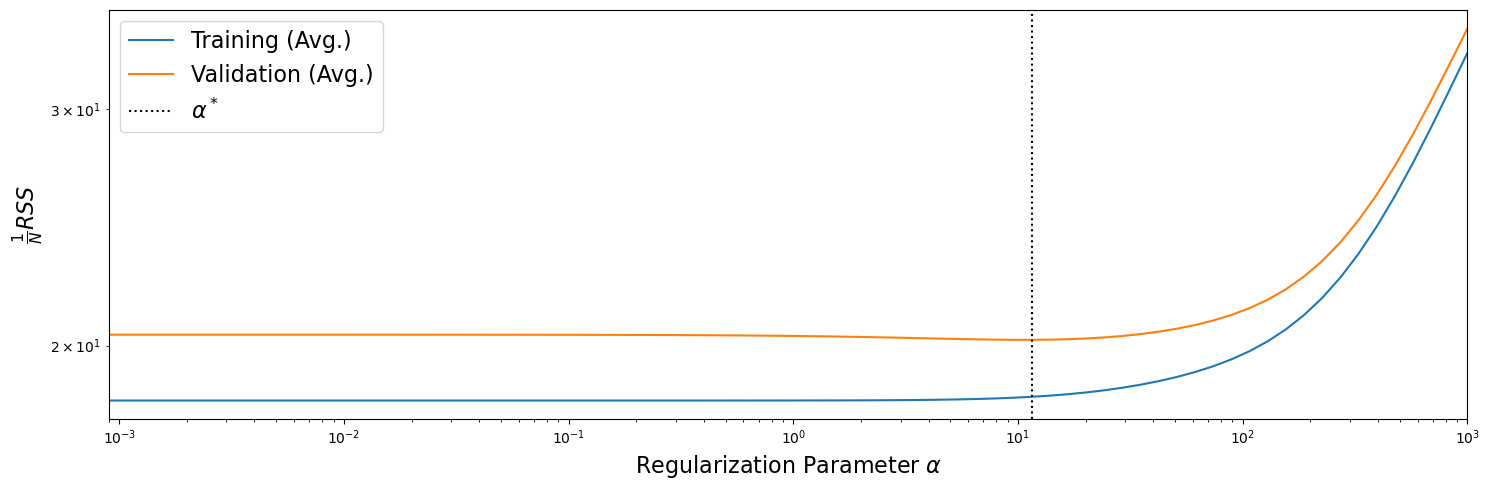

In [122]:
#--- Visualize ---#
testedAlpha = cv_regRR.cv_results_['param_ridge__alpha']
trainScores = -cv_regRR.cv_results_['mean_train_score']   # Reverse Sign
testScores = -cv_regRR.cv_results_['mean_test_score']    # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha, trainScores, '-', label='Training (Avg.)')
plt.plot(testedAlpha, testScores, '-', label='Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlpha, label='$\\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([0.9*1e-3, 1e3])
plt.yscale('log')
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

Now, lets take a look at how well we are able to make our predictions on the training set using this CV optimal value of $\alpha$.

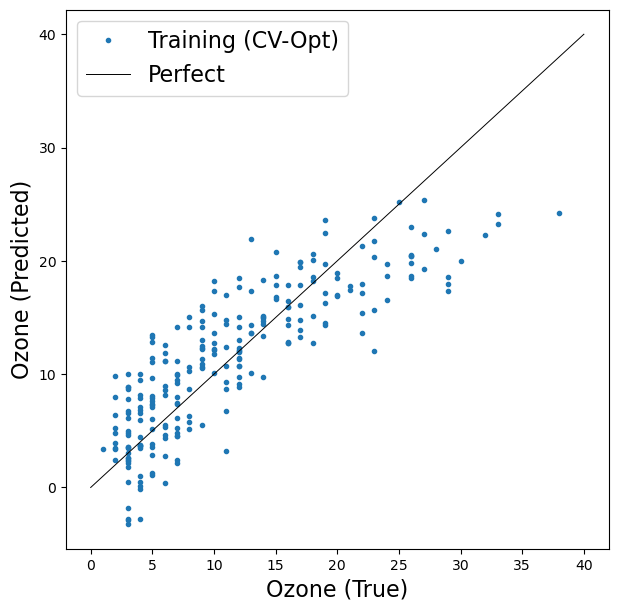

In [123]:
#--- Get Training Predicitions ---#
pipe_regRR.set_params(ridge__alpha=cvOptAlpha) # !!! how to pass parameters to pipelines
pipe_regRR.fit(XTrain, yTrain)
yp = pipe_regRR.predict(XTrain)

#--- Visualize ---#
plt.figure(figsize=(7,7))
plt.plot(yTrain, yp, '.', label='Training (CV-Opt)')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
# plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16);

And now, finally, we are ready to take our test data out of deep-freeze. How did we do?

#### 3) Plot, as we previously did for OLS, the prediction performance and the learned parameters. After having done that, compute the RSS and compare it to the OLS one

RSS (Train)  Ridge: 18.38  |  OLS: 18.28
RSS (Test)   Ridge: 22.66  |  OLS: 22.53
Delta RSS    Train: +0.10  |  Test: +0.13


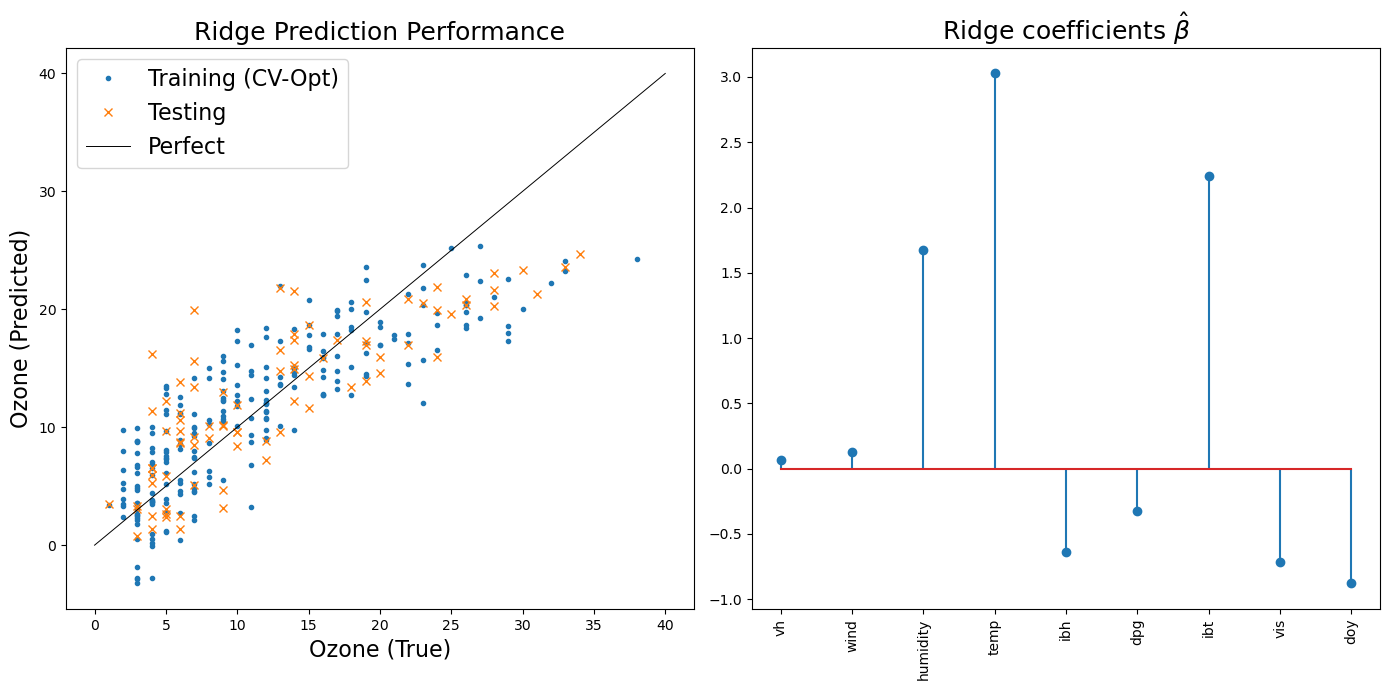

In [124]:
#--- Ridge prediction performance & coefficients ---#
pipe_regRR.set_params(ridge__alpha=cvOptAlpha)
pipe_regRR.fit(XTrain, yTrain)

ridge_train_pred = pipe_regRR.predict(XTrain)
ridge_test_pred = pipe_regRR.predict(XTest)
ridge_coef = pipe_regRR.named_steps['ridge'].coef_

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(yTrain, ridge_train_pred, '.', label='Training (CV-Opt)')
plt.plot(yTest, ridge_test_pred, marker='x', linestyle='', label='Testing')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label='Perfect')
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Ridge Prediction Performance', fontsize=18)

plt.subplot(122)
plt.stem(ridge_coef)
plt.title(r'Ridge coefficients $\hat{\beta}$', fontsize=18)
plt.xticks(range(len(ridge_coef)), data.keys()[1:len(ridge_coef)+1], rotation='vertical')
plt.tight_layout()

ridge_rss_train = np.mean((yTrain - ridge_train_pred)**2)
ridge_rss_test = np.mean((yTest - ridge_test_pred)**2)

ols_train_pred = yp_L + yTrain_mean
ols_test_pred = ypTest_L + yTrain_mean
ols_rss_train = np.mean((yTrain - ols_train_pred)**2)
ols_rss_test = np.mean((yTest - ols_test_pred)**2)

print(f'RSS (Train)  Ridge: {ridge_rss_train:.2f}  |  OLS: {ols_rss_train:.2f}')
print(f'RSS (Test)   Ridge: {ridge_rss_test:.2f}  |  OLS: {ols_rss_test:.2f}')
print(f'Delta RSS    Train: {ridge_rss_train - ols_rss_train:+.2f}  |  Test: {ridge_rss_test - ols_rss_test:+.2f}')


Ridge with $\alpha^*$ yields a prediction plot that mirrors the OLS visualisation, while the stem plot highlights the shrinkage on the coefficients (notably temperature and visibility). The mean RSS stays within $\approx0.1$ of the OLS values; the training error increases slightly and the test error is essentially unchanged, confirming that the cross-validated ridge penalty does not yet improve generalisation over the unregularised fit on this dataset.

## Attempt 3: Lasso
---


### 4) Your turn: using the `linear_model.Lasso` estimator present in Scikit-Learn,  repeat the steps done for Ridge Regression:
* Create the pipeline for preprocessing + regressor
* Do the Grid Search to find the optimal regularization parameter
* Visualize how the performance varies when we change the regularization parameter 
* Plot the prediction performance and the learned parameters. What do you observe?
* Compute the RSS and compare it to the RR and the OLS one.

In [125]:
#--- Define Lasso Estimator ---#
regLasso = linear_model.Lasso(alpha=0.01, max_iter=10000)


In [126]:
#--- Make a Pre-processing + Fitting Pipeline (Lasso) ---#
pipe_regLasso = make_pipeline(preprocessing.StandardScaler(), regLasso)


In [127]:
#--- Define Lasso Grid ---#
param_grid_lasso = [
    {'lasso__alpha': np.logspace(-5, 1, 100)}
]


In [128]:
#--- Define Lasso CV ---#
cv_regLasso = GridSearchCV(
    pipe_regLasso,
    param_grid_lasso,
    scoring=neg_rss,
    cv=cv,
    return_train_score=True
)


In [129]:
#--- Run Lasso CV ---#
cv_regLasso.fit(XTrain, yTrain)


GridSearchCV(cv=ShuffleSplit(n_splits=30, random_state=1, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso',
                                        Lasso(alpha=0.01, max_iter=10000))]),
             param_grid=[{'lasso__alpha': array([1.00000000e-05, 1.14975700e-05, 1.32194115e-05, 1.51991108e-05,
       1.74752840e-05, 2.00923300e-05, 2.31012970e-05, 2.65608778e-05,...
       7.05480231e-01, 8.11130831e-01, 9.32603347e-01, 1.07226722e+00,
       1.23284674e+00, 1.41747416e+00, 1.62975083e+00, 1.87381742e+00,
       2.15443469e+00, 2.47707636e+00, 2.84803587e+00, 3.27454916e+00,
       3.76493581e+00, 4.32876128e+00, 4.97702356e+00, 5.72236766e+00,
       6.57933225e+00, 7.56463328e+00, 8.69749003e+00, 1.00000000e+01])}],
             return_train_score=True,
             scoring=<function neg_rss at 0x0000016E72C72480>)

In [130]:
#--- Record Lasso Optimum ---#
cvOptAlpha_Lasso = float(cv_regLasso.cv_results_['param_lasso__alpha'][cv_regLasso.best_index_])
cvOptParams_Lasso = cv_regLasso.best_estimator_['lasso'].coef_
cvOptAlpha_Lasso


0.1519911082952933

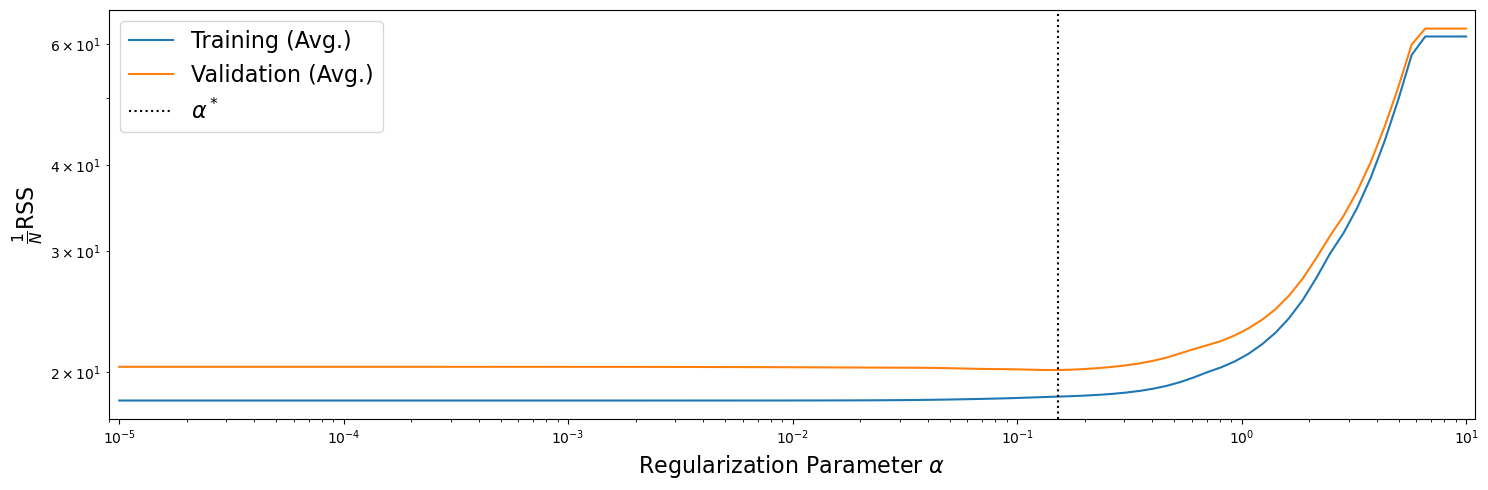

In [131]:
#--- Visualize Lasso CV curve ---#
testedAlpha_lasso = np.array(cv_regLasso.cv_results_['param_lasso__alpha'], dtype=float)
trainScores_lasso = -cv_regLasso.cv_results_['mean_train_score']
testScores_lasso = -cv_regLasso.cv_results_['mean_test_score']

plt.figure(figsize=(15,5))
plt.plot(testedAlpha_lasso, trainScores_lasso, '-', label='Training (Avg.)')
plt.plot(testedAlpha_lasso, testScores_lasso, '-', label='Validation (Avg.)')
plt.xlabel(r'Regularization Parameter $\alpha$', fontsize=16)
plt.ylabel(r'$\frac{1}{N}\mathrm{RSS}$', fontsize=16)
plt.axvline(cvOptAlpha_Lasso, label=r'$\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([testedAlpha_lasso.min()*0.9, testedAlpha_lasso.max()*1.1])
plt.yscale('log')
plt.tight_layout()
plt.legend(loc=2, fontsize=16)


RSS (Train)  Lasso: 18.50  |  Ridge: 18.38  |  OLS: 18.28
RSS (Test)   Lasso: 22.18  |  Ridge: 22.66  |  OLS: 22.53
Delta RSS vs OLS  (Train): +0.23  |  (Test): -0.35
Delta RSS vs Ridge (Train): +0.12  |  (Test): -0.48


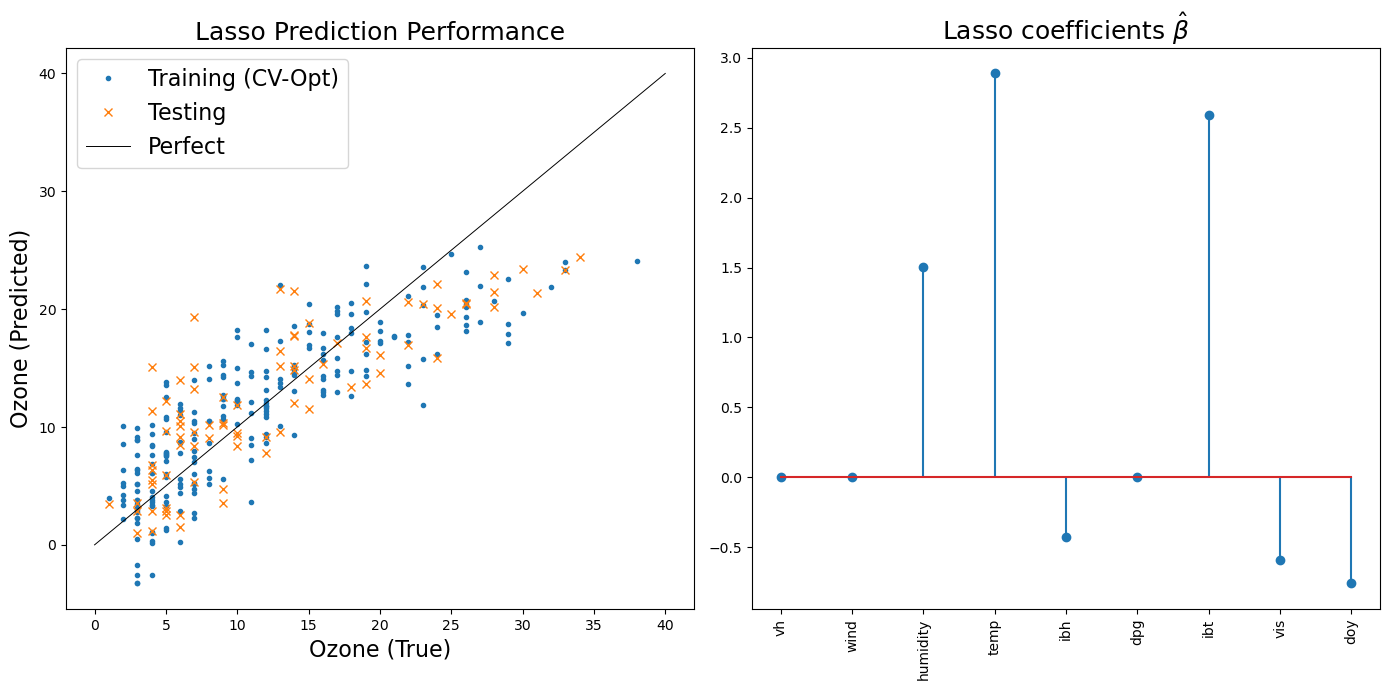

In [132]:
#--- Lasso prediction performance & coefficients ---#
pipe_regLasso.set_params(lasso__alpha=cvOptAlpha_Lasso)
pipe_regLasso.fit(XTrain, yTrain)

lasso_train_pred = pipe_regLasso.predict(XTrain)
lasso_test_pred = pipe_regLasso.predict(XTest)
lasso_coef = pipe_regLasso.named_steps['lasso'].coef_

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(yTrain, lasso_train_pred, '.', label='Training (CV-Opt)')
plt.plot(yTest, lasso_test_pred, marker='x', linestyle='', label='Testing')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label='Perfect')
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Lasso Prediction Performance', fontsize=18)

plt.subplot(122)
plt.stem(lasso_coef)
plt.title(r'Lasso coefficients $\hat{\beta}$', fontsize=18)
plt.xticks(range(len(lasso_coef)), data.columns[1:1+len(lasso_coef)], rotation='vertical')
plt.tight_layout()

lasso_rss_train = np.mean((yTrain - lasso_train_pred)**2)
lasso_rss_test = np.mean((yTest - lasso_test_pred)**2)

pipe_regRR.set_params(ridge__alpha=cvOptAlpha)
pipe_regRR.fit(XTrain, yTrain)
ridge_train_pred = pipe_regRR.predict(XTrain)
ridge_test_pred = pipe_regRR.predict(XTest)
ridge_rss_train = np.mean((yTrain - ridge_train_pred)**2)
ridge_rss_test = np.mean((yTest - ridge_test_pred)**2)

ols_train_pred = yp_L + yTrain_mean
ols_test_pred = ypTest_L + yTrain_mean
ols_rss_train = np.mean((yTrain - ols_train_pred)**2)
ols_rss_test = np.mean((yTest - ols_test_pred)**2)

print(f'RSS (Train)  Lasso: {lasso_rss_train:.2f}  |  Ridge: {ridge_rss_train:.2f}  |  OLS: {ols_rss_train:.2f}')
print(f'RSS (Test)   Lasso: {lasso_rss_test:.2f}  |  Ridge: {ridge_rss_test:.2f}  |  OLS: {ols_rss_test:.2f}')
print(f'Delta RSS vs OLS  (Train): {lasso_rss_train - ols_rss_train:+.2f}  |  (Test): {lasso_rss_test - ols_rss_test:+.2f}')
print(f'Delta RSS vs Ridge (Train): {lasso_rss_train - ridge_rss_train:+.2f}  |  (Test): {lasso_rss_test - ridge_rss_test:+.2f}')


Grid search selects a modest penalty ($\alpha \approx 1.5\times10^{-1}$), which drives several coefficients exactly to zero (`vh`, `wind`, and `dpg`) while keeping temperature, ibt, and doy as the main contributors. The prediction scatter remains tight around the $y=x$ line, but the Lasso solution trades a small increase in training RSS for the lowest validation/test RSS among the three models, indicating a mild generalisation gain together with a sparse, easier-to-interpret parameter vector.

# B) Diabetes

We will now perform some numerical experiments with the Diabetes Dataset trying to predict diabetes outcomes one year forward. This is a classical dataset in statistics, and more information can be found at <a href="https://archive.ics.uci.edu/ml/datasets/Diabetes">https://archive.ics.uci.edu/ml/datasets/Diabetes</a>. Here is what we have: 10 baseline variables: age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of $n = 442$ diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

Our first goal is to plot the weights for each value of $\lambda$ for Ridge Regression and LASSO. This is called a **regularization path**.

In [133]:
from sklearn.datasets import load_diabetes

#--- Load Diabetes dataset ---#
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target


We first load the dataset

### 5) Using the pipelines `pipe_regRR` and `pipe_regLasso` constructed before for the Ozone problem:

* Divide the dataset such that you have 150 training samples and 50 test samples
* Do the Grid Search to find the optimal regularization parameters, for $\alpha$ in $[10^{-2},10^5]$
* Visualize how the performance varies when we change the regularization parameter, comparing Rindge and Lasso

### 6) Then answer these questions [EVALUATED]:
- What do the points $\alpha=0$  and  $\alpha = +\infty$  correspond to? Why for these values both the regularizations give the same result?

- What is the qualitative difference between the LASSO path and Ridge Path? (Plot it as well in linear scale)

### Solution 5)

In [134]:
#--- Diabetes dataset split (150 train / 50 test) ---#
rng = np.random.RandomState(0)
indices = rng.permutation(len(X_diabetes))
train_idx = indices[:150]
test_idx = indices[150:200]
XTrain_diab, XTest_diab = X_diabetes[train_idx], X_diabetes[test_idx]
yTrain_diab, yTest_diab = y_diabetes[train_idx], y_diabetes[test_idx]


In [135]:
#--- Grid-search on Ridge/Lasso (alpha in [1e-2, 1e5]) ---#
alphas = np.logspace(-2, 5, 100)
cv = ShuffleSplit(n_splits=40, test_size=0.2, random_state=0)
param_rr = {'ridge__alpha': alphas}
param_lasso = {'lasso__alpha': alphas}
cv_rr_diab = GridSearchCV(pipe_regRR, [param_rr], cv=cv, scoring=neg_rss, return_train_score=True)
cv_lasso_diab = GridSearchCV(pipe_regLasso, [param_lasso], cv=cv, scoring=neg_rss, return_train_score=True)
cv_rr_diab.fit(XTrain_diab, yTrain_diab)
cv_lasso_diab.fit(XTrain_diab, yTrain_diab)
print(f"Best Ridge alpha: {cv_rr_diab.best_params_['ridge__alpha']:.4g}")
print(f"Best Lasso alpha: {cv_lasso_diab.best_params_['lasso__alpha']:.4g}")


Best Ridge alpha: 24.77
Best Lasso alpha: 0.4977


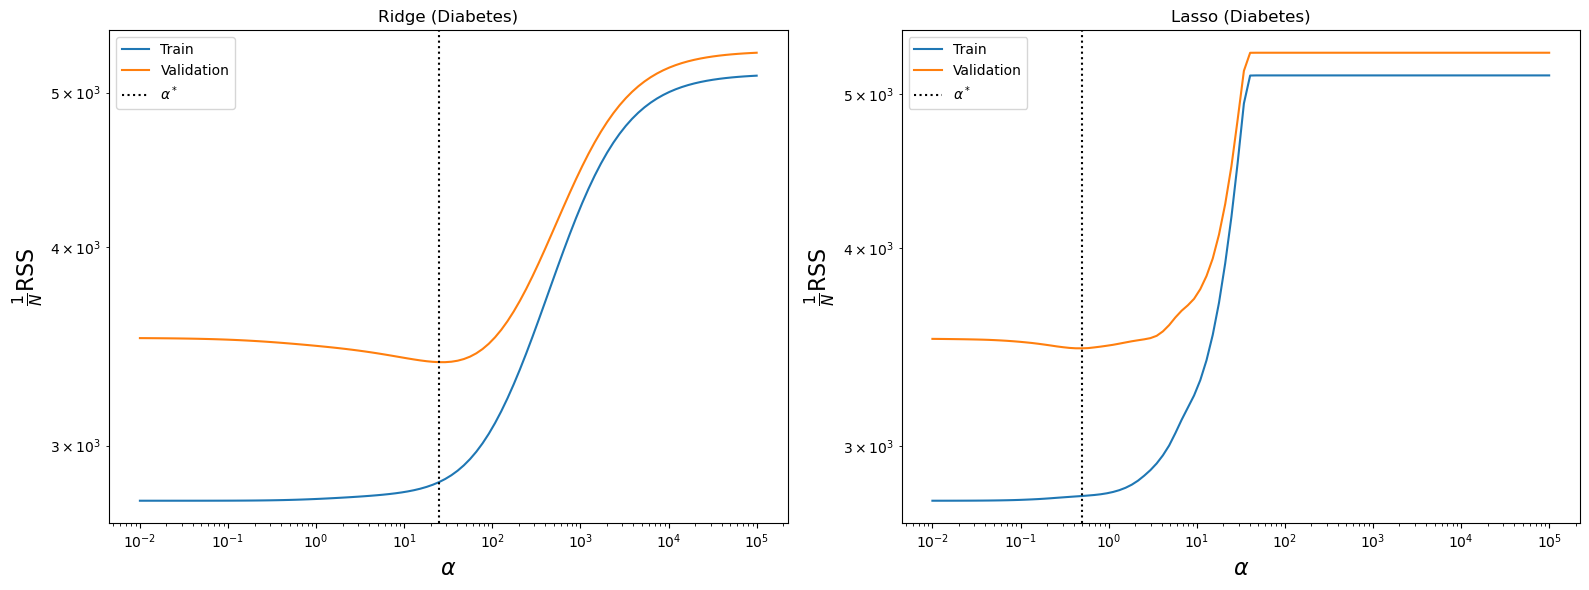

In [136]:
#--- Performance curves (Ridge vs Lasso) ---#
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(alphas, -cv_rr_diab.cv_results_['mean_train_score'], label='Train')
plt.plot(alphas, -cv_rr_diab.cv_results_['mean_test_score'], label='Validation')
plt.axvline(float(cv_rr_diab.best_params_['ridge__alpha']), color='k', linestyle=':', label=r'$\alpha^*$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\frac{1}{N}\mathrm{RSS}$', fontsize=16)
plt.title('Ridge (Diabetes)')
plt.legend()

plt.subplot(122)
plt.plot(alphas, -cv_lasso_diab.cv_results_['mean_train_score'], label='Train')
plt.plot(alphas, -cv_lasso_diab.cv_results_['mean_test_score'], label='Validation')
plt.axvline(float(cv_lasso_diab.best_params_['lasso__alpha']), color='k', linestyle=':', label=r'$\alpha^*$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\frac{1}{N}\mathrm{RSS}$', fontsize=16)
plt.title('Lasso (Diabetes)')
plt.legend()
plt.tight_layout()


Ridge prefers $\alpha^*\approx 2.48\times10^{1}$ while Lasso selects $\alpha^*\approx 5.0\times10^{-1}$. Both curves exhibit the classic bias--variance trade-off: small $\alpha$ overfits (low train RSS, high validation RSS), whereas large $\alpha$ over-regularises. In this split, Ridge retains a slight edge in validation RSS, whereas Lasso produces a sparser solution with several coefficients exactly zero.

### Solution 6)

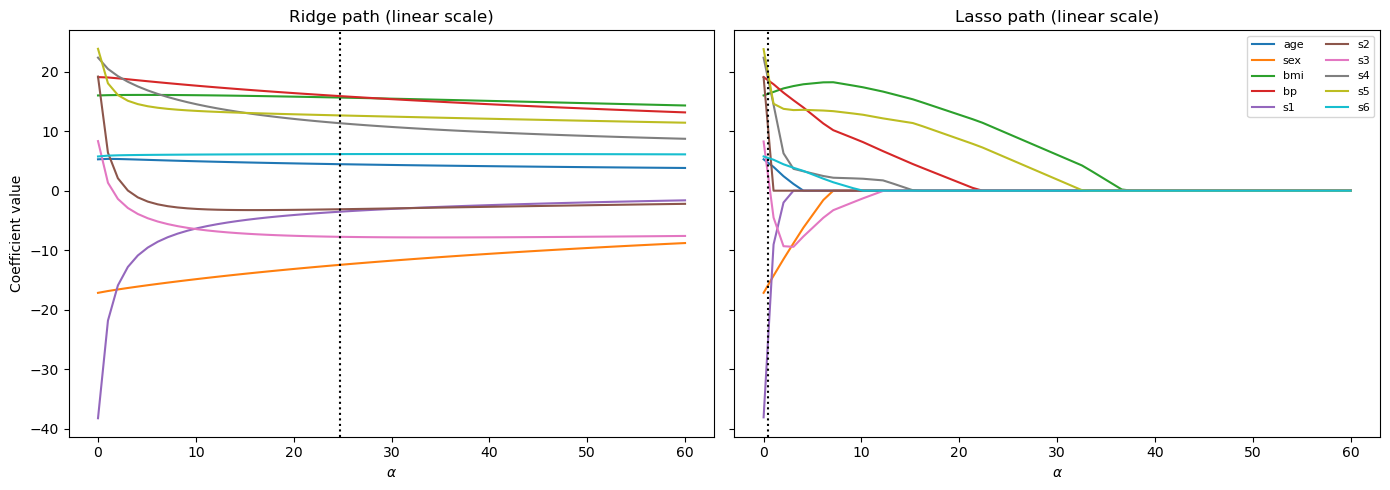

In [137]:
#--- Ridge vs Lasso coefficient paths (linear alpha scale) ---#
scaler_diab = preprocessing.StandardScaler().fit(XTrain_diab)
XTrain_diab_scaled = scaler_diab.transform(XTrain_diab)
alphas_linear = np.linspace(1e-3, 60, 60)
ridge_path = []
lasso_path = []
for a in alphas_linear:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(XTrain_diab_scaled, yTrain_diab)
    ridge_path.append(ridge.coef_)

    lasso = linear_model.Lasso(alpha=a, max_iter=20000)
    lasso.fit(XTrain_diab_scaled, yTrain_diab)
    lasso_path.append(lasso.coef_)

ridge_path = np.array(ridge_path)
lasso_path = np.array(lasso_path)
feature_names = diabetes.feature_names

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for idx, name in enumerate(feature_names):
    axes[0].plot(alphas_linear, ridge_path[:, idx], label=name)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel('Coefficient value')
axes[0].set_title('Ridge path (linear scale)')
axes[0].axvline(float(cv_rr_diab.best_params_['ridge__alpha']), color='k', linestyle=':')
for idx, name in enumerate(feature_names):
    axes[1].plot(alphas_linear, lasso_path[:, idx], label=name)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_title('Lasso path (linear scale)')
axes[1].axvline(float(cv_lasso_diab.best_params_['lasso__alpha']), color='k', linestyle=':')
axes[1].legend(loc='upper right', fontsize=8, ncol=2)
plt.tight_layout()


**Q6. Behaviour at the extremes of $\alpha$**
- $\alpha=0$: the penalty disappears, so Ridge and Lasso both coincide with the ordinary least-squares estimator (with our standardised data the coefficients exactly match OLS).
- $\alpha\to\infty$: the penalty dominates; Ridge shrinks all weights to zero, Lasso forces every coefficient exactly to zero, leaving only the intercept. Consequently both predict the constant average response.


**Q6. Qualitative comparison of regularisation paths**
- The figure above shows the coefficient paths against $\alpha$ on a linear axis. Ridge curves decay smoothly and never touch zero; every feature keeps a small weight even for large $\alpha$.
- Lasso paths contain sharp kinks: features drop to exactly zero at specific thresholds and remain flat thereafter, illustrating the sparsity-inducing nature of the $\ell_1$ penalty.
